In [1]:
from kalman_filter import *
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
rng = np.random.default_rng()

from utils import *
from trajectories import *

CUT = 5 # cutoff the first few datapoints because they have too much noise so it is not a fair comparison.
T = 250 # how long to simulate the trajectory # 100
num_traj = 1

## Generate Trajectories

In [2]:
task_name = 'circular' # Choose from'circular', 'motion', 'so3', or 'accel'
A, B, C, Q, R, x0, state_dim, input_dim, obs_dim = sys_params[task_name]
u_seq = 0.05 * (rng.random(size=(num_traj, T, input_dim))*2 - 1)
traj, meas = generate_traj(num_traj, T, A, B, C, Q, R, x0, u_seq, state_dim, input_dim, obs_dim)
# traj  has shape=(num_traj, T, state_dim)
# meas  has shape=(num_traj, T, obs_dim)
# u_seq has shape=(num_traj, T, input_dim)
print("A", A)
print("B", B)
print("C", C)

A [[ 0.9998477  -0.01745241]
 [ 0.01745241  0.9998477 ]]
B [[0.5]
 [0.7]]
C [[1. 0.]
 [0. 1.]]


Trajectory shape (250, 2)
Measured shape (250, 2)


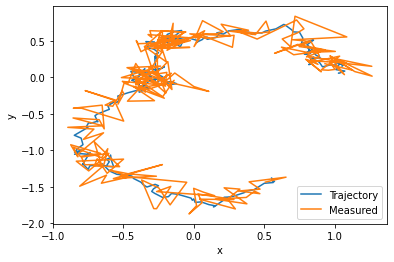

In [3]:
# plot a sample trajectory and noisy measurements
plot({'Trajectory': traj[0], 'Measured': meas[0]})

In [11]:
print("u_seq[0]", u_seq[0].shape)
print("meas[0]", meas[0].shape)
A_found, B_found, C_found, X_found = sys_id(meas[0], T, u_seq[0], order_estimate=2, window=100)
print("A", A_found)
print("B", B_found)
print("C", C_found)
print("X", X_found.T)

u_seq[0] (250, 1)
meas[0] (250, 2)
A [[ 1.0097547  -0.02842785]
 [ 0.02156071  1.01161879]]
B [[ 0.01578746]
 [-0.04669022]]
C [[ 0.13257255 -0.99094727]
 [ 1.16521952 -0.29324594]]
X [[ 0.39335059  0.3168009 ]
 [ 0.39116835  0.31332537]
 [ 0.38613098  0.32198686]
 [ 0.37921687  0.3388471 ]
 [ 0.36976271  0.34311209]
 [ 0.36003169  0.35569086]
 [ 0.3563307   0.35647651]
 [ 0.35191104  0.36357509]
 [ 0.34543583  0.36062484]
 [ 0.3377699   0.36009154]
 [ 0.32924581  0.35417026]
 [ 0.32686777  0.35153099]
 [ 0.32333171  0.34388958]
 [ 0.31970138  0.33259643]
 [ 0.31065497  0.32524406]
 [ 0.30414956  0.32094398]
 [ 0.29690623  0.31533414]
 [ 0.28832221  0.31112143]
 [ 0.27955848  0.29882898]
 [ 0.26736674  0.28981733]
 [ 0.26251343  0.28661221]
 [ 0.24719585  0.28573824]
 [ 0.24072348  0.28518151]
 [ 0.23268454  0.27265153]
 [ 0.22539358  0.27214722]
 [ 0.21199219  0.26835992]
 [ 0.19878418  0.26822945]
 [ 0.19166574  0.26182868]
 [ 0.18491516  0.25719976]
 [ 0.17824252  0.24590592]
 [ 0.1

### Generalized System Identification: Update on the identified system at each timestep

In [8]:
id_filtered_gen = np.zeros(shape=(num_traj, T, state_dim))

for i in range(num_traj):
    # Use the same data as before, but now no peeking on what are the actual A, B matrices
    A_unk, B_unk, C_unk = np.zeros(shape=(state_dim, state_dim)), np.zeros(shape=(state_dim, input_dim)), np.zeros(shape=(obs_dim, state_dim))
    kinematics = KFilter(A_unk, B_unk, C_unk, Q, R, state=x0)
    id_fltr = np.zeros(shape=(T,state_dim))
    
    for t in range(20, T):
        A_found, B_found, C_found, X_seq = sys_id(meas[i], t, u_seq[i], order_estimate=state_dim, window=3)
        print("A found", A_found)
        print("B found", B_found)
        print("C found", C_found)
        kinematics.A = A_found
        kinematics.B = B_found
        kinematics.C = C_found
        kinematics.predict(u_seq[i][t])
        kinematics.update(meas[i][t])
        id_fltr[t] = kinematics.state
    id_filtered_gen[i] = id_fltr
    
err_id_fltr = np.linalg.norm(id_filtered_gen[:, CUT:, :] - traj[:, CUT:, :])**2 / num_traj / T
print("Average Squared Error", err_id_fltr)

A found [[ 1.00052068  0.07193689]
 [ 0.01046883 -0.370777  ]]
B found [[-0.90136403]
 [-3.91417424]]
C found [[-1.7226929   0.36500193]
 [-0.27012914 -0.22312969]]
A found [[ 0.99340507  0.03236844]
 [ 0.00562194 -0.56840132]]
B found [[-0.40727311]
 [-2.72025691]]
C found [[-1.73300215  0.30478365]
 [-0.28627922 -0.26900956]]
A found [[ 0.99996822  0.06893249]
 [ 0.01653712 -0.46365956]]
B found [[-0.7427462 ]
 [-2.68660469]]
C found [[-1.73522478  0.29613833]
 [-0.28823481 -0.24330898]]
A found [[ 0.99964207  0.05124558]
 [-0.00292287 -0.47339751]]
B found [[-0.80745758]
 [-1.79483656]]
C found [[-1.68877309  0.32473788]
 [-0.28817571 -0.25111077]]
A found [[ 0.99956395  0.05352804]
 [ 0.00682496 -0.39970355]]
B found [[-0.80217551]
 [-1.42512149]]
C found [[-1.70020268  0.33389295]
 [-0.29530615 -0.22667309]]
A found [[ 1.00150982  0.05132854]
 [ 0.01106648 -0.45809203]]
B found [[-0.8423107 ]
 [-1.76632817]]
C found [[-1.7274538   0.29930422]
 [-0.31025457 -0.23489482]]
A found [[

A found [[ 0.98584157 -0.01626059]
 [ 0.02761101  1.00855405]]
B found [[-0.03761927]
 [-0.48993189]]
C found [[-2.06040109  0.92020849]
 [-1.18905712 -1.28735748]]
A found [[ 0.98521235 -0.0184953 ]
 [ 0.02692941  1.00709822]]
B found [[-0.02005822]
 [-0.47628974]]
C found [[-2.0767894   0.89670768]
 [-1.18346166 -1.31592378]]
A found [[ 0.98493442 -0.01984022]
 [ 0.02637466  1.00552539]]
B found [[-0.00445847]
 [-0.44889005]]
C found [[-2.08024459  0.89428325]
 [-1.18122011 -1.33082204]]
A found [[ 0.98511577 -0.01833393]
 [ 0.02667283  1.00634597]]
B found [[-0.01490128]
 [-0.47159834]]
C found [[-2.07492982  0.90970506]
 [-1.18600384 -1.33190735]]
A found [[ 0.98497307 -0.01494876]
 [ 0.02683798  1.00536556]]
B found [[-0.04602583]
 [-0.46061512]]
C found [[-2.08283155  0.90074587]
 [-1.19346273 -1.33856511]]
A found [[ 0.98483909 -0.01785305]
 [ 0.02644038  1.00548631]]
B found [[-0.04644768]
 [-0.45536348]]
C found [[-2.07519136  0.8983193 ]
 [-1.18452216 -1.34882202]]
A found [[

A found [[ 0.98492981 -0.01668293]
 [ 0.02110349  0.99081794]]
B found [[-0.09824755]
 [-0.16845548]]
C found [[-2.11242248  0.9263238 ]
 [-1.12098913 -1.59259107]]
A found [[ 0.98480794 -0.01620423]
 [ 0.02114393  0.99018555]]
B found [[-0.10267821]
 [-0.15541217]]
C found [[-2.10776617  0.94626146]
 [-1.12920773 -1.5918436 ]]
A found [[ 0.98515563 -0.01681004]
 [ 0.02189705  0.98949144]]
B found [[-0.10496647]
 [-0.16629805]]
C found [[-2.10748379  0.94417863]
 [-1.12657003 -1.60020127]]
A found [[ 0.98529459 -0.01682457]
 [ 0.02175871  0.9892837 ]]
B found [[-0.09718607]
 [-0.1751276 ]]
C found [[-2.11121175  0.95225062]
 [-1.13393793 -1.58753772]]
A found [[ 0.98521323 -0.01679062]
 [ 0.021995    0.98928476]]
B found [[-0.10264484]
 [-0.16358969]]
C found [[-2.11303227  0.93752142]
 [-1.12605532 -1.5934078 ]]
A found [[ 0.98483793 -0.01688974]
 [ 0.02111717  0.98924943]]
B found [[-0.10135519]
 [-0.15219007]]
C found [[-2.12582905  0.91155954]
 [-1.11201788 -1.60865926]]
A found [[

A found [[ 0.9921866  -0.01569892]
 [ 0.02170648  0.98431929]]
B found [[-0.1603719 ]
 [-0.20996108]]
C found [[-2.22724719  0.96279939]
 [-1.20516761 -1.59633139]]
A found [[ 0.9917961  -0.01589958]
 [ 0.02301103  0.98511728]]
B found [[-0.15948416]
 [-0.2113034 ]]
C found [[-2.22736437  0.9688379 ]
 [-1.22156627 -1.59242895]]
A found [[ 0.9935359  -0.01507854]
 [ 0.02171519  0.9845267 ]]
B found [[-0.16811917]
 [-0.20680082]]
C found [[-2.23227795  0.97355797]
 [-1.23677365 -1.5903567 ]]
A found [[ 0.99335499 -0.01516825]
 [ 0.0226532   0.98508609]]
B found [[-0.16409484]
 [-0.21376044]]
C found [[-2.23138788  0.98470226]
 [-1.25547003 -1.58680405]]
A found [[ 0.99408522 -0.01459808]
 [ 0.02326048  0.98558944]]
B found [[-0.17584566]
 [-0.22055106]]
C found [[-2.22823453  1.00616476]
 [-1.2836511  -1.57839979]]
A found [[ 0.9935942  -0.01482219]
 [ 0.02391386  0.98594389]]
B found [[-0.17930117]
 [-0.2160377 ]]
C found [[-2.22385066  1.02333526]
 [-1.30565581 -1.57270409]]
A found [[

A found [[ 1.00112426 -0.01268601]
 [ 0.02497268  0.99204523]]
B found [[-0.1596856 ]
 [ 0.02382952]]
C found [[-1.50944333  2.03823544]
 [-2.76596416 -1.04021826]]
A found [[ 1.00119522 -0.01274779]
 [ 0.02592564  0.9940427 ]]
B found [[-0.16319633]
 [ 0.01084271]]
C found [[-1.47036858  2.06910541]
 [-2.79934097 -1.01505119]]
A found [[ 1.00097921 -0.01329823]
 [ 0.02562695  0.99383575]]
B found [[-0.15981343]
 [ 0.0152508 ]]
C found [[-1.43603613  2.0961949 ]
 [-2.82656623 -0.9910754 ]]
A found [[ 1.00015097 -0.01468778]
 [ 0.02553754  0.99396042]]
B found [[-0.14815071]
 [ 0.01799025]]
C found [[-1.4059583   2.12267047]
 [-2.85574295 -0.96606441]]
A found [[ 0.99963907 -0.01531811]
 [ 0.02455472  0.99273991]]
B found [[-0.14685084]
 [ 0.02254929]]
C found [[-1.38890674  2.13547521]
 [-2.87692096 -0.96932589]]
A found [[ 1.00035596 -0.01439621]
 [ 0.02488721  0.99346039]]
B found [[-0.14149963]
 [ 0.03076679]]
C found [[-1.34513976  2.16782801]
 [-2.90664645 -0.93019085]]
A found [[

In [ ]:
plot({'Trajectory': traj[0], 'Measured': meas[0], 'Id Filtered': id_filtered_gen[0]})